# d-HSIC Independence test amongst SDGs

Joint Independence test

$H_0: \mathbb{P}_{\mathbf{X}} = \mathbb{P}_{X_1} \mathbb{P}_{X_2} \dots \mathbb{P}_{X_d}$

We compute these depedencies on a goal level. We work with the concatenated time-series, where each country corresponds to an independent sample.

In this notebook we work with groupings of countries according to income, development, north or south.

## Implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ortho_group
import pickle
from sklearn.metrics import pairwise_distances, pairwise_kernels
import sklearn.gaussian_process as gp
from sklearn.gaussian_process.kernels import RBF
import networkx as nx
from tqdm.notebook import tqdm

import os
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning) 

import pandas as pd

import copy

## Loading standardised imputed data set
We load first of all the standardised imputed data set which we have generated with the previous notebook.

In [2]:
targets_values_i = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/targets_values_i_up_arr_wb.pkl', 'rb'))
goals_values_i = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/goals_values_i_up_arr_wb.pkl', 'rb'))

In [3]:
c = pd.read_csv('/Users/saravallejomengod/MathsYear4/M4R/utils/countries_wb.csv', dtype=str, delimiter=';', header=None)
countries = list(c[0])

groups = pd.read_csv(r'/Users/saravallejomengod/MathsYear4/M4R/utils/groups.csv')
groups.replace({"Democratic People's Republic of Korea": "Korea, Dem. People's Rep.", 'Gambia': 'Gambia, The', 'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom', 'Congo': 'Congo, Rep.', 'Democratic Republic of the Congo': 'Congo, Dem. Rep.', 'Czechia': 'Czech Republic', 'Iran (Islamic Republic of)': 'Iran, Islamic Rep.', "Côte d'Ivoire": "Cote d'Ivoire", 'Kyrgyzstan': 'Kyrgyz Republic', "Lao People's Democratic Republic": 'Lao PDR', 'Republic of Moldova': 'Moldova', 'Micronesia (Federated States of)': 'Micronesia, Fed. Sts.', 'Slovakia': 'Slovak Republic', 'Viet Nam': 'Vietnam', 'Egypt': 'Egypt, Arab Rep.', 'United Republic of Tanzania': 'Tanzania','United States of America': 'United States', 'Venezuela (Bolivarian Republic of)': 'Venezuela, RB', 'Yemen': 'Yemen, Rep.', 'Bahamas': 'Bahamas, The', 'Bolivia (Plurinational State of)': 'Bolivia'}, inplace=True)

info = pd.read_csv(r'/Users/saravallejomengod/MathsYear4/M4R/utils/wb_info.csv', header=None)

In [4]:
# removes some countries in-place
countries.remove('Micronesia, Fed. Sts.')
groups['Global South'].drop(index=1, inplace=True)

In [5]:
groups

,Global North,Global South,Least Developed Countries (LDC),Land Locked Developing Countries (LLDC),Small Island Developing States (SIDS),G20,Emerging Markets (BRICS + N-11),OPEC,Low Income,Lower middle Income,Upper middle Income,High Income
0,Albania,Fiji,"Yemen, Rep.",Afghanistan,Antigua and Barbuda,Australia,Bangladesh,Algeria,Afghanistan,Angola,Albania,Antigua and Barbuda
1,Austria,"Micronesia, Fed. Sts.",Afghanistan,Armenia,"Bahamas, The",Canada,"Egypt, Arab Rep.",Angola,Burkina Faso,Bangladesh,Argentina,Australia
2,Belarus,Tonga,Burundi,Azerbaijan,Barbados,Saudi Arabia,Indonesia,Equatorial Guinea,Burundi,Bhutan,Armenia,Austria
3,Belgium,Vanuatu,Angola,Bhutan,Belize,United States,"Iran, Islamic Rep.",Gabon,Central African Republic,Bolivia,Azerbaijan,"Bahamas, The"
4,Bosnia and Herzegovina,Tuvalu,Benin,Bolivia,Comoros,India,Mexico,"Iran, Islamic Rep.",Chad,Cambodia,Belarus,Bahrain
...,...,...,...,...,...,...,...,...,...,...,...,...
133,NaN,Tajikistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
134,NaN,Turkmenistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
135,NaN,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
136,NaN,Uzbekistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We generate a list for all unique targets with their corresponding indicators.

In [6]:
targets = list(info[4].unique())
targets.remove('T')
dict_targets = {}

for target in targets:
    t = info[0].where(info[4] == target)

    dict_targets[target] = [i for i in t if str(i) != 'nan']

Similarly, we create a list with all unique SDGs and their corresponding targets.

In [7]:
goals = list(info[3].unique())
goals.remove('T')
dict_goals = {}

for goal in goals:
    g = info[4].where(info[3] == goal)

    dict_goals[goal] = [t for t in g if str(t) != 'nan']
    dict_goals[goal] = list(set(dict_goals[goal]))

Since we will work with groupings of countries, we prepare the data in the following way. We create a dictionary with groupings as keys; such that the corresponding value is a 17-vector where each entry corresponds to an SDG. These entries are matrices with each row corresponding to a country.

In [8]:
# data preparation
groups_prep_g = {}

for group in groups:
    print(group)
    
    groups_prep_g[group] = np.empty(18, dtype=object)
    
    for g, goal in enumerate(goals):
        g_list = []
        for country in groups[group].dropna():
            g_list.append(np.asarray(goals_values_i[country][g]))

        groups_prep_g[group][g] = np.asarray(g_list)


Global North
Global South
Least Developed Countries (LDC)
Land Locked Developing Countries (LLDC)
Small Island Developing States (SIDS)
G20
Emerging Markets (BRICS + N-11)
OPEC
Low Income
Lower middle Income
Upper middle Income
High Income


In [9]:
groups_prep_g['Low Income'][0].shape

(28, 447)

In [11]:
# data preparation for targets
groups_prep_t = {}

for group in groups:
    print(group)
    
    groups_prep_t[group] = np.empty(76, dtype=object)
    
    for t, target in enumerate(targets):
        t_list = []
        for country in groups[group].dropna():
            t_list.append(np.asarray(targets_values_i[country][t]))

        groups_prep_t[group][t] = np.asarray(t_list)

Global North
Global South
Least Developed Countries (LDC)
Land Locked Developing Countries (LLDC)
Small Island Developing States (SIDS)
G20
Emerging Markets (BRICS + N-11)
OPEC
Low Income
Lower middle Income
Upper middle Income
High Income


## d-HSIC between goals

We compute the d-HSIC on a goal level and perform and independence test.

### Combinations

We need to compute this statistic on all possible d-combinations of the 17 SDGs. Therefore, we create the following functions that given a set and a number r computes all possible combinations without order.

In [12]:
def combinations(iterable, r):
    # combinations('ABCD', 2) --> AB AC AD BC BD CD
    # combinations(range(4), 3) --> 012 013 023 123
    pool = tuple(iterable)
    n = len(pool)
    if r > n:
        return
    indices = list(range(r))
    yield list(pool[i] for i in indices)
    while True:
        for i in reversed(range(r)):
            if indices[i] != i + n - r:
                break
        else:
            return
        indices[i] += 1
        for j in range(i+1, r):
            indices[j] = indices[j-1] + 1
        yield list(pool[i] for i in indices)

In [13]:
def combinations_tuple(iterable, r):
    # combinations('ABCD', 2) --> AB AC AD BC BD CD
    # combinations(range(4), 3) --> 012 013 023 123
    pool = tuple(iterable)
    n = len(pool)
    if r > n:
        return
    indices = list(range(r))
    yield tuple(pool[i] for i in indices)
    while True:
        for i in reversed(range(r)):
            if indices[i] != i + n - r:
                break
        else:
            return
        indices[i] += 1
        for j in range(i+1, r):
            indices[j] = indices[j-1] + 1
        yield tuple(pool[i] for i in indices)

## d-HSIC implementation

In [14]:
def width(Z):
    """
    Computes the median heuristic for the kernel bandwidth
    """
    dist_mat = pairwise_distances(Z, metric='euclidean')
    width_Z = np.median(dist_mat[dist_mat > 0])
    return width_Z

In [15]:
def make_K_list(X_list, n_samples, n_nodes):
    """
    Computes the kernel matrices of the variables in X_array, where each column represents one variable.
    Returns a list of the kernel matrices of each variable.
    """
    k_list = list(pairwise_kernels(X_list[i], metric='rbf', gamma=0.5/(width(X_list[i])**2)) for i in range(n_nodes))
    return k_list

In [16]:
def dHSIC(k_list):
    """
    Computes the dHSIC statistic
    """
    n_nodes = len(k_list)
    n_samples = k_list[0].shape[0]
    
    term1, term2, term3 = 1, 1, 2/n_samples    
    for j in range(n_nodes):
        term1 = term1 * k_list[j]
        term2 = term2 * np.sum(k_list[j]) / (n_samples**2)
        term3 = term3 * np.sum(k_list[j], axis=0) / n_samples
    term1_sum = np.sum(term1)
    term3_sum = np.sum(term3)
    dHSIC = term1_sum/(n_samples**2) + term2 - term3_sum
    return dHSIC

In [17]:
def dHSIC_permutation(k_list, n_samples, n_nodes, n_perms=5000, alpha=0.05):
    """
    Approximates the null distribution by permutating all variables
    """
    # initiating statistics
    statistics = np.zeros(n_perms)
    
    for i in range(n_perms):
        term1 = k_list[0]
        term2 = np.sum(k_list[0])/(n_samples**2)
        term3 = 2 * np.sum(k_list[0], axis=0) / (n_samples**2)

        for j in range(1, n_nodes):
            index_perm = np.random.permutation(k_list[j].shape[0])
            k_perm = k_list[j][index_perm, index_perm[:, None]]

            term1 = term1 * k_perm
            term2 = term2 * np.sum(k_perm) / (n_samples**2)
            term3 = term3 * np.sum(k_perm, axis=0) / n_samples

        term1_sum = np.sum(term1)
        term3_sum = np.sum(term3)

        statistics[i] = term1_sum/(n_samples**2) + term2 - term3_sum
    
    statistics_sort = np.sort(statistics)
    # computing 1-alpha threshold
    threshold = statistics_sort[round((1-alpha)*n_perms)]
    return threshold

In [18]:
def joint_independence_test(X_list, n_perms=5000, alpha=0.05):
    """
    Performs the independence test with HSIC and returns an accept or reject statement
    
    Inputs:
    X_list: list of variables, each having dimensions (n_samples, n_obs)  
    n_perms: number of permutations performed when bootstrapping the null
    alpha: rejection threshold of the test
    make_K: function called to construct the kernel matrix 
    
    Returns:
    reject: 1 if null rejected, 0 if null accepted
    
    """
    
    n_nodes = len(X_list)
    n_samples, n_obs = X_list[0].shape
    
    # compute list of kernel matrices
    K_list = make_K_list(X_list, n_samples, n_nodes)
    
    # statistic and threshold
    stat = dHSIC(K_list)
    threshold = dHSIC_permutation(K_list, n_samples, n_nodes)
    reject = int(stat > threshold)
    
    return reject

In [19]:
def dHSIC_links(group, groups_data, iterable, stop_after_2=False):
    #For given dictionary groups_data, take nd.array corresponding to group
    # ie. continents_prep_g['Europe']
    group_arr = groups_data[group]
    
    K = len(iterable)   #number of total variables (17 goals, 76 targets)
    edges = {}          #initialize dictionary with edges according to dependencies found
    Adj2 = np.zeros((K,K))  #initialize KxK adjacency matrix for d=2
    d = 2   #initial number of variables for dHSIC
    e = 0  
    
    indexes = np.arange(K)    #create vector corresponding to indexes of iterable
    #find all possible d-combinations of indexes without order
    g_combinations = list(combinations_tuple(indexes, d))   
    
    #iterate until no possible combinations of independent variables are left
    while len(g_combinations) >0 :
        print("combinations: ", d)
        print("number of combinations available: ", len(g_combinations))
        
        f = 0
        hsic_found = {}   #initialize dictionary with decision rule for each d-combination considered
        #iterate over all combinations considered
        for comb in g_combinations: 
            #create X_list[i] = observed data for variable comb[i]
            X_list = []
            for i in range(d):
                X_list.append(group_arr[comb[i]])
            
            #test joint independence: if reject H0, reject=1 (dependency found)
            reject = joint_independence_test(X_list)   
            
            hsic_found[comb] = reject
            if reject == 1:
                e += 1
                f += 1
                edges[e] = tuple(iterable[i] for i in comb)  #add edge to graph according to dependency found
                if d == 2:
                    Adj2[comb[0], comb[1]] = reject
                    Adj2[comb[1], comb[0]] = reject
                    
        print("Edges found with " ,d, "nodes: ", f)
        
        if stop_after_2==True:
            break
            
        d +=1 #update d
        if d==K+1:
            break #stop iteration if d is greater than available variables
        
        #Find possible d-combinations of iterable. Note that if a dependency has already been found
        #among elements of a combination <d, then we should not consider the combinations involving 
        #these elements
        g_combinations_all = list(combinations_tuple(indexes, d))
        g_combinations = copy.deepcopy(g_combinations_all)

        for comb_n in g_combinations_all:
            #consider all possible sub-combinations of d-1 elements in each comb of g_combinations_all
            gg = list(combinations_tuple(comb_n, d-1)) 
            for l in range(len(gg)):
                # for each sub_combination a dependency among its elements has already been found if 
                # that combination is not in hsic_found (so was already not considered in the previous 
                # step), or if it is but has value = 1 (there was a dependency only for the joint dist 
                # of all d-1 elements)
                if (gg[l] in hsic_found and hsic_found[gg[l]]==1) or (gg[l] not in hsic_found):
                    g_combinations.remove(comb_n)  #do not consider such combination
                    break
                   
    return edges, Adj2

## Experiments on Goal level

Run the above algorithm for finding the high-order dependencies among SDGs in the lowest possible order, ie. starting from pariwise dependencies to d-dependencies.

We do this for the different groupings of our dataset and save the results.

In [20]:
edges_gs, Adj2_gs = dHSIC_links('Global South', groups_prep_g, goals)

combinations:  2
number of combinations available:  136
Edges found with  2 nodes:  128
combinations:  3
number of combinations available:  1
Edges found with  3 nodes:  0


In [21]:
edges_gn, Adj2_gn = dHSIC_links('Global North', groups_prep_g, goals)

combinations:  2
number of combinations available:  136
Edges found with  2 nodes:  81
combinations:  3
number of combinations available:  85
Edges found with  3 nodes:  12
combinations:  4
number of combinations available:  47
Edges found with  4 nodes:  1
combinations:  5
number of combinations available:  14
Edges found with  5 nodes:  0
combinations:  6
number of combinations available:  2
Edges found with  6 nodes:  0


In [22]:
edges_li, Adj2_li = dHSIC_links('Low Income', groups_prep_g, goals)

combinations:  2
number of combinations available:  136
Edges found with  2 nodes:  29
combinations:  3
number of combinations available:  339
Edges found with  3 nodes:  15
combinations:  4
number of combinations available:  517
Edges found with  4 nodes:  3
combinations:  5
number of combinations available:  438
Edges found with  5 nodes:  1
combinations:  6
number of combinations available:  193
Edges found with  6 nodes:  0
combinations:  7
number of combinations available:  39
Edges found with  7 nodes:  0
combinations:  8
number of combinations available:  2
Edges found with  8 nodes:  0


In [23]:
edges_hi, Adj2_hi = dHSIC_links('High Income', groups_prep_g, goals)

combinations:  2
number of combinations available:  136
Edges found with  2 nodes:  105
combinations:  3
number of combinations available:  19
Edges found with  3 nodes:  3
combinations:  4
number of combinations available:  2
Edges found with  4 nodes:  0


In [24]:
edges_lmi, Adj2_lmi = dHSIC_links('Lower middle Income', groups_prep_g, goals)

combinations:  2
number of combinations available:  136
Edges found with  2 nodes:  46
combinations:  3
number of combinations available:  207
Edges found with  3 nodes:  12
combinations:  4
number of combinations available:  185
Edges found with  4 nodes:  2
combinations:  5
number of combinations available:  68
Edges found with  5 nodes:  0
combinations:  6
number of combinations available:  6
Edges found with  6 nodes:  0


In [25]:
edges_umi, Adj2_umi = dHSIC_links('Upper middle Income', groups_prep_g, goals)

combinations:  2
number of combinations available:  136
Edges found with  2 nodes:  52
combinations:  3
number of combinations available:  175
Edges found with  3 nodes:  15
combinations:  4
number of combinations available:  132
Edges found with  4 nodes:  5
combinations:  5
number of combinations available:  37
Edges found with  5 nodes:  0
combinations:  6
number of combinations available:  2
Edges found with  6 nodes:  0


In [27]:
# better save these precious data
hs = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/dHSIC_GS.pkl', 'wb')
pickle.dump(edges_gs, hs)
hs.close()
hs = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/dHSIC_GN.pkl', 'wb')
pickle.dump(edges_gn, hs)
hs.close()
hs = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/dHSIC_LI.pkl', 'wb')
pickle.dump(edges_li, hs)
hs.close()
hs = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/dHSIC_HI.pkl', 'wb')
pickle.dump(edges_hi, hs)
hs.close()
hs = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/dHSIC_LMI.pkl', 'wb')
pickle.dump(edges_lmi, hs)
hs.close()
hs = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/dHSIC_UMI.pkl', 'wb')
pickle.dump(edges_umi, hs)
hs.close()

## Visualisation

In [28]:
import networkx as nx
!pip install hypernetx

%load_ext autoreload
%autoreload 2
import hypernetx as hnx

import matplotlib.colors as mcolors
import matplotlib.cm as cm

You should consider upgrading via the '/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [29]:
n_labels = {}
for i in range(17):
    n_labels[i] = i+1

### Global South

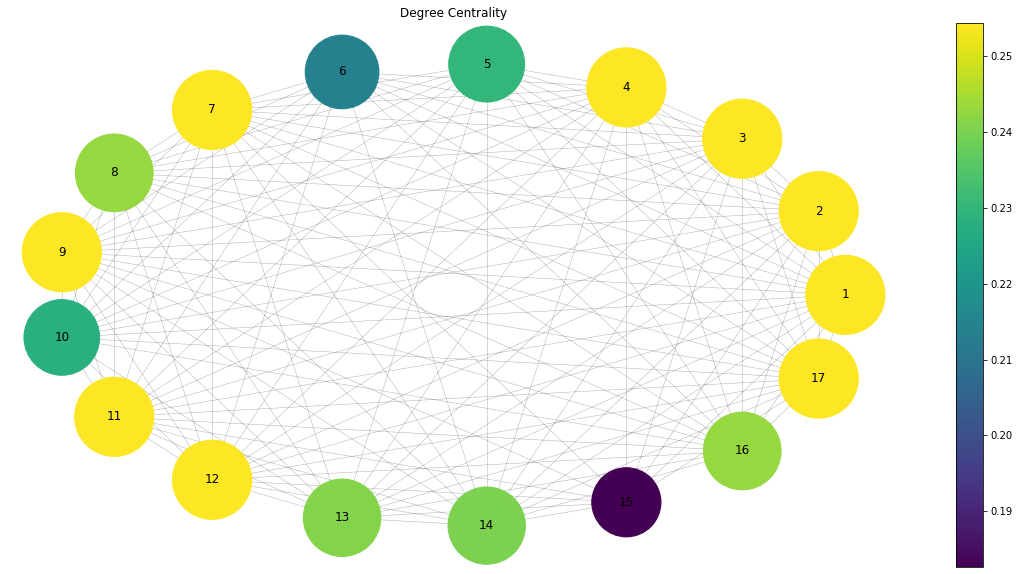

In [147]:
G = nx.Graph(Adj2_gs)     #define graph
pos = nx.circular_layout(G)  # compute graph layout
degree = nx.eigenvector_centrality(G)     #compute degree centrality

plt.figure(figsize=(20, 10))   
plt.axis('off')
plt.title('Degree Centrality')

#define nodes with color and size depending on degree
nodes = nx.draw_networkx_nodes(G, pos, node_size= list(12**4*i+1000 for i in degree.values()), cmap=plt.cm.viridis,
                       node_color=list(i for i in degree.values()), nodelist=list(degree.keys()))
#nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1))
labels=nx.draw_networkx_labels(G,pos, labels=n_labels)
#draw edges
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.3)
plt.colorbar(nodes)
plt.show(G)

In [80]:
degree

{0: 0.2543171167729078,
 1: 0.2543171167729078,
 2: 0.2543171167729078,
 3: 0.2543171167729078,
 4: 0.2297825228917583,
 5: 0.21388358080471834,
 6: 0.2543171167729078,
 7: 0.2430149213740984,
 8: 0.2543171167729078,
 9: 0.22815421969473676,
 10: 0.2543171167729078,
 11: 0.2543171167729078,
 12: 0.2410847182905677,
 13: 0.2402018135662151,
 14: 0.18268398524039492,
 15: 0.2430149213740984,
 16: 0.2543171167729078}

### Global North

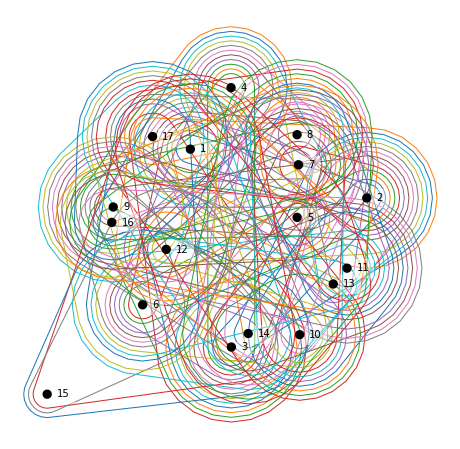

In [33]:
Hgn = hnx.Hypergraph(edges_gn)
hnx.draw(Hgn, with_edge_labels=False)

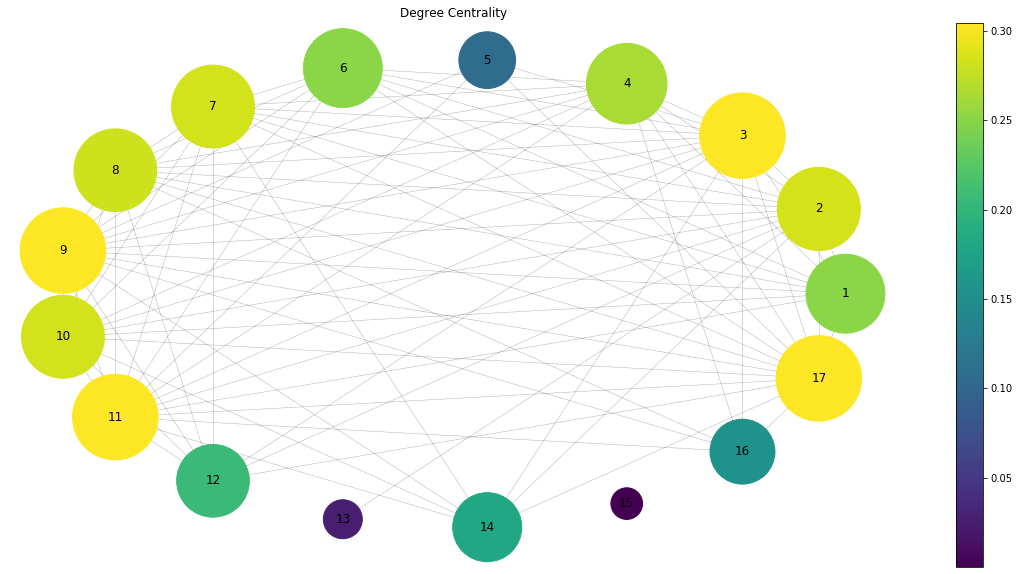

In [146]:
G = nx.Graph(Adj2_gn)     #define graph
pos = nx.circular_layout(G)  # compute graph layout
degree = nx.eigenvector_centrality(G)     #compute degree centrality

plt.figure(figsize=(20, 10))   
plt.axis('off')
plt.title('Degree Centrality')

#define nodes with color and size depending on degree
nodes = nx.draw_networkx_nodes(G, pos, node_size= list(12**4*i+1000 for i in degree.values()), cmap=plt.cm.viridis,
                       node_color=list(i for i in degree.values()), nodelist=list(degree.keys()))
#nodes.set_norm(mcolors.SymLogNorm(linthresh=0.001, linscale=1, vmin=0.0, vmax=1.0))
labels=nx.draw_networkx_labels(G,pos, labels=n_labels)
#draw edges
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.3)
plt.colorbar(nodes)
plt.show(G)

In [78]:
degree

{0: 0.25187538118457353,
 1: 0.28526438307674895,
 2: 0.3043919182645195,
 3: 0.2643867717788894,
 4: 0.1069809833045329,
 5: 0.25187538118457353,
 6: 0.28323998392736516,
 7: 0.2810663752579862,
 8: 0.3043919182645195,
 9: 0.2832399839273651,
 10: 0.3043919182645195,
 11: 0.20651452383441202,
 12: 0.02506454154356103,
 13: 0.18181885062859507,
 14: 4.773375732037844e-10,
 15: 0.15490675395977074,
 16: 0.3043919182645195}

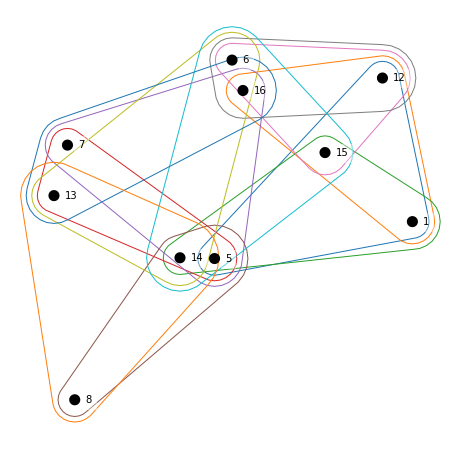

In [35]:
Hgn_restrict_edges3 = Hgn.restrict_to_edges(list(e for e in edges_gn if len(edges_gn[e])==3))
hnx.draw(Hgn_restrict_edges3, with_edge_labels=False)

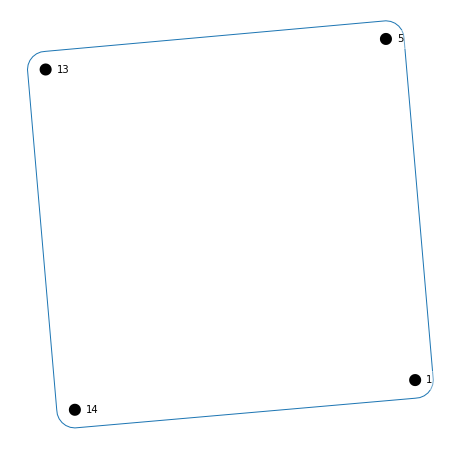

In [37]:
Hgn_restrict_edges4 = Hgn.restrict_to_edges(list(e for e in edges_gn if len(edges_gn[e])==4))
hnx.draw(Hgn_restrict_edges4, with_edge_labels=False)

### Low Income

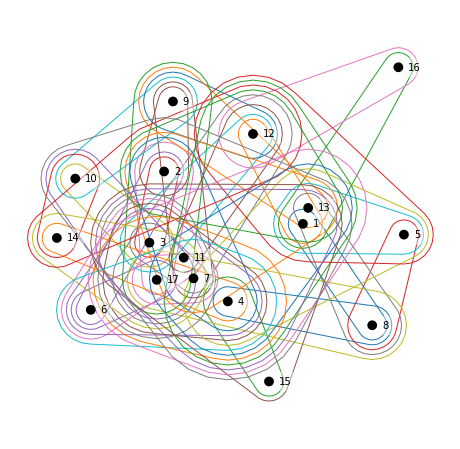

In [38]:
Hli = hnx.Hypergraph(edges_li)
hnx.draw(Hli, with_edge_labels=False)

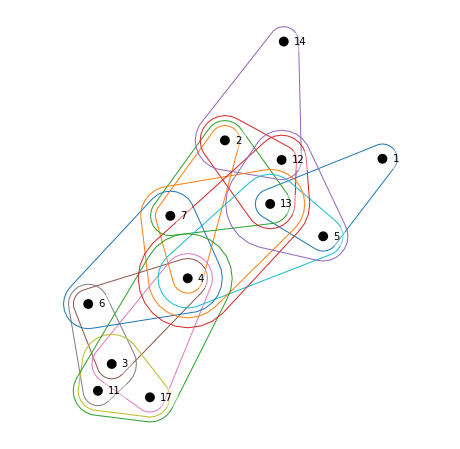

In [39]:
Hli_restrict_edges3 = Hli.restrict_to_edges(list(e for e in edges_li if len(edges_li[e])==3))
hnx.draw(Hli_restrict_edges3, with_edge_labels=False)

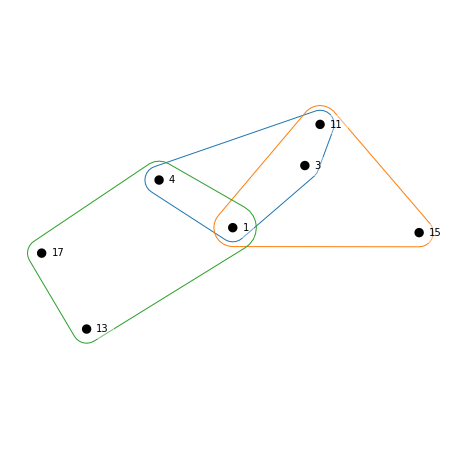

In [40]:
Hli_restrict_edges4 = Hli.restrict_to_edges(list(e for e in edges_li if len(edges_li[e])==4))
hnx.draw(Hli_restrict_edges4, with_edge_labels=False)

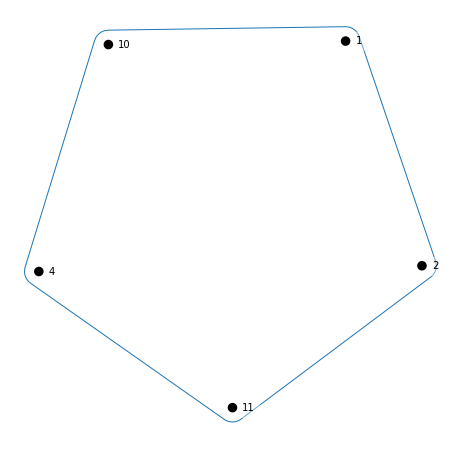

In [41]:
Hli_restrict_edges5 = Hli.restrict_to_edges(list(e for e in edges_li if len(edges_li[e])==5))
hnx.draw(Hli_restrict_edges5, with_edge_labels=False)

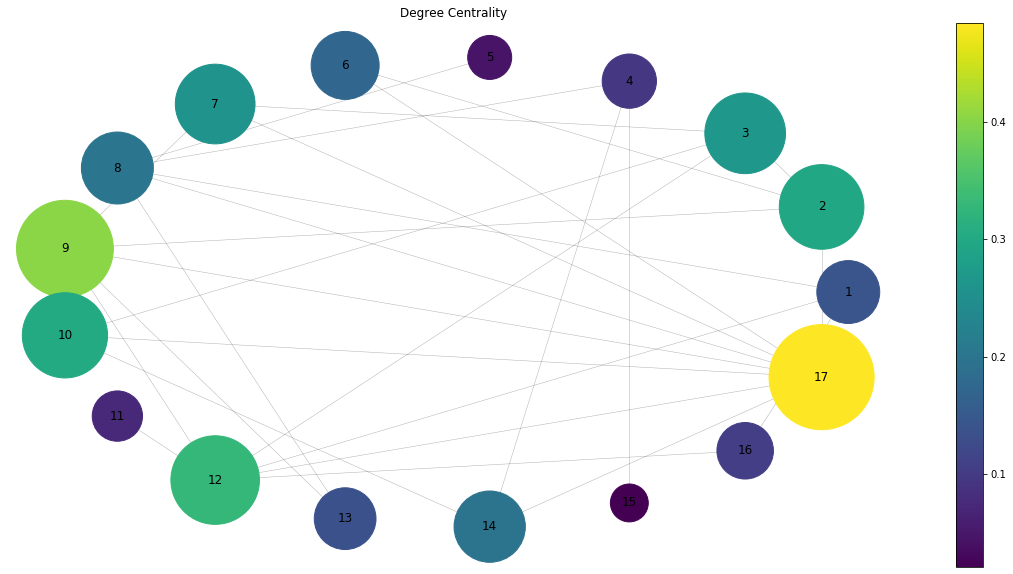

In [148]:
G = nx.Graph(Adj2_li)     #define graph
pos = nx.circular_layout(G)  # compute graph layout
degree = nx.eigenvector_centrality(G)     #compute degree centrality

plt.figure(figsize=(20, 10))   
plt.axis('off')
plt.title('Degree Centrality')

#define nodes with color and size depending on degree
nodes = nx.draw_networkx_nodes(G, pos, node_size= list(12**4*i+1000 for i in degree.values()), cmap=plt.cm.viridis,
                       node_color=list(i for i in degree.values()), nodelist=list(degree.keys()))
#nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1, vmin=0.0, vmax=1.0))
labels=nx.draw_networkx_labels(G,pos, labels=n_labels)
#draw edges
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.3)
plt.colorbar(nodes)
plt.show(G)

### High Income

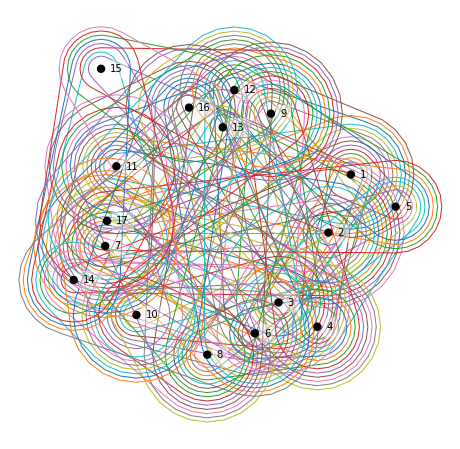

In [43]:
Hhi = hnx.Hypergraph(edges_hi)
hnx.draw(Hhi, with_edge_labels=False)

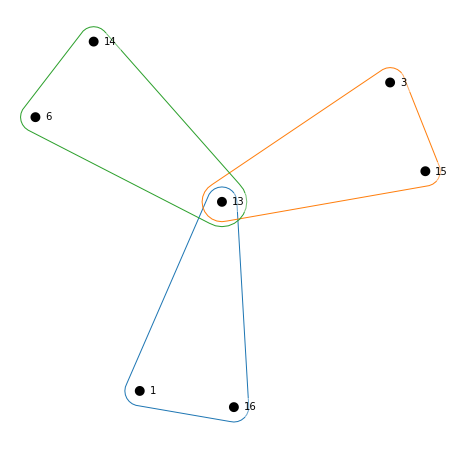

In [44]:
Hhi_restrict_edges3 = Hhi.restrict_to_edges(list(e for e in edges_hi if len(edges_hi[e])==3))
hnx.draw(Hhi_restrict_edges3, with_edge_labels=False)

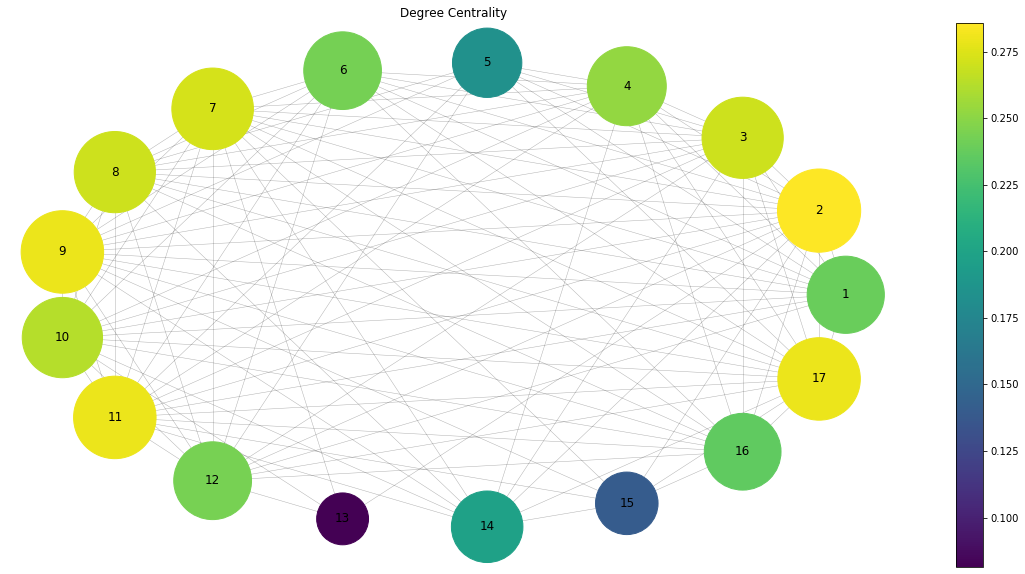

In [149]:
G = nx.Graph(Adj2_hi)     #define graph
pos = nx.circular_layout(G)  # compute graph layout
degree = nx.eigenvector_centrality(G)     #compute degree centrality

plt.figure(figsize=(20, 10))   
plt.axis('off')
plt.title('Degree Centrality')

#define nodes with color and size depending on degree
nodes = nx.draw_networkx_nodes(G, pos, node_size= list(12**4*i+1000 for i in degree.values()), cmap=plt.cm.viridis,
                       node_color=list(i for i in degree.values()), nodelist=list(degree.keys()))
#nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1))
labels=nx.draw_networkx_labels(G,pos, labels=n_labels)
#draw edges
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.3)
plt.colorbar(nodes)
plt.show(G)

### Lower middle Income

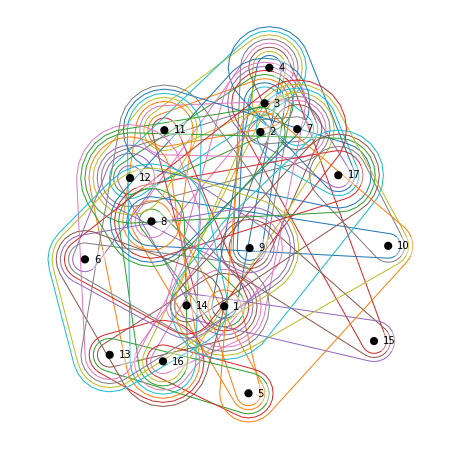

In [46]:
Hlmi = hnx.Hypergraph(edges_lmi)
hnx.draw(Hlmi, with_edge_labels=False)

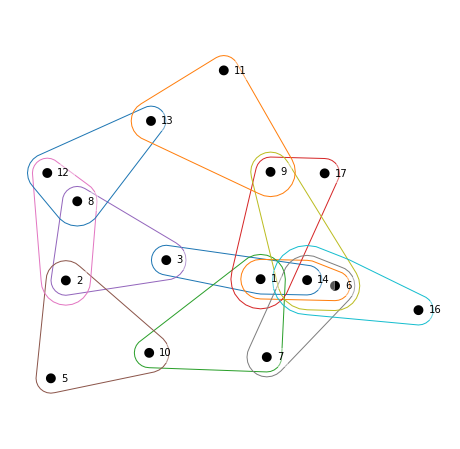

In [47]:
Hlmi_restrict_edges3 = Hlmi.restrict_to_edges(list(e for e in edges_lmi if len(edges_lmi[e])==3))
hnx.draw(Hlmi_restrict_edges3, with_edge_labels=False)

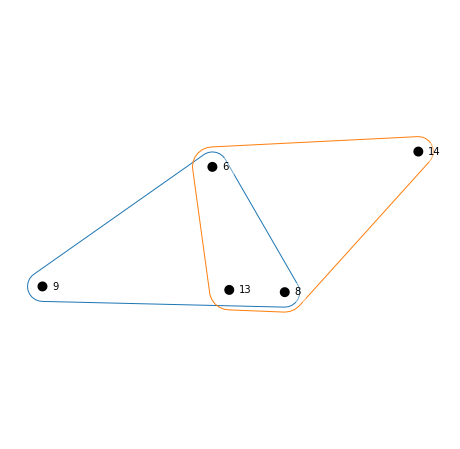

In [48]:
Hlmi_restrict_edges4 = Hlmi.restrict_to_edges(list(e for e in edges_lmi if len(edges_lmi[e])==4))
hnx.draw(Hlmi_restrict_edges4, with_edge_labels=False)

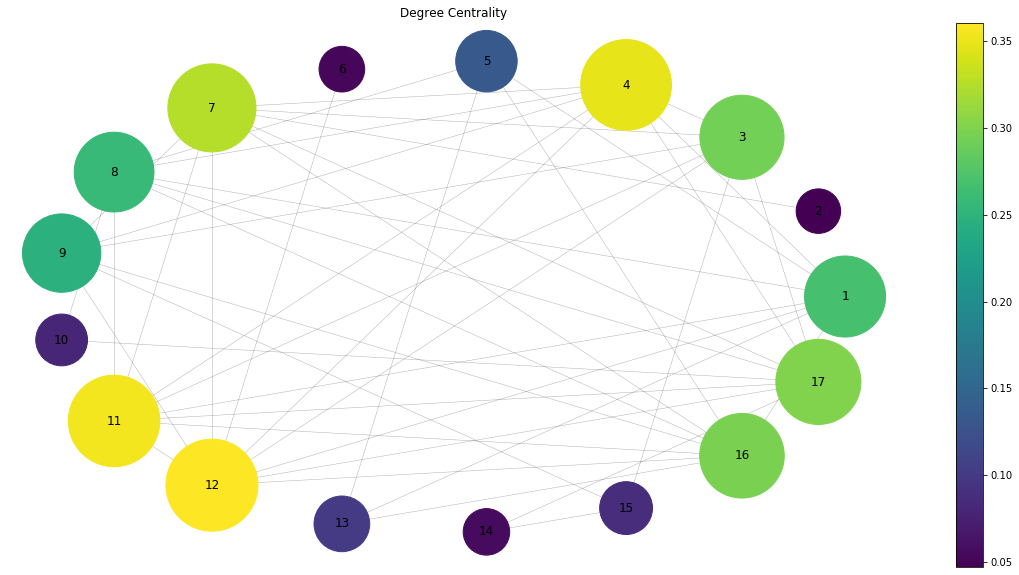

In [150]:
G = nx.Graph(Adj2_lmi)     #define graph
pos = nx.circular_layout(G)  # compute graph layout
degree = nx.eigenvector_centrality(G)     #compute degree centrality

plt.figure(figsize=(20, 10))   
plt.axis('off')
plt.title('Degree Centrality')

#define nodes with color and size depending on degree
nodes = nx.draw_networkx_nodes(G, pos, node_size= list(12**4*i+1000 for i in degree.values()), cmap=plt.cm.viridis,
                       node_color=list(i for i in degree.values()), nodelist=list(degree.keys()))
#nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1))
labels=nx.draw_networkx_labels(G,pos, labels=n_labels)
#draw edges
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.3)
plt.colorbar(nodes)
plt.show(G)

### Upper middle Income

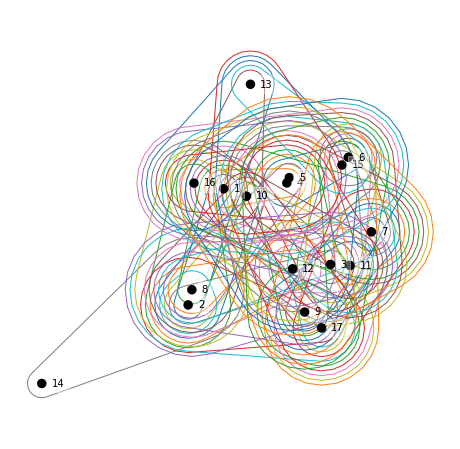

In [50]:
Humi = hnx.Hypergraph(edges_umi)
hnx.draw(Humi, with_edge_labels=False)

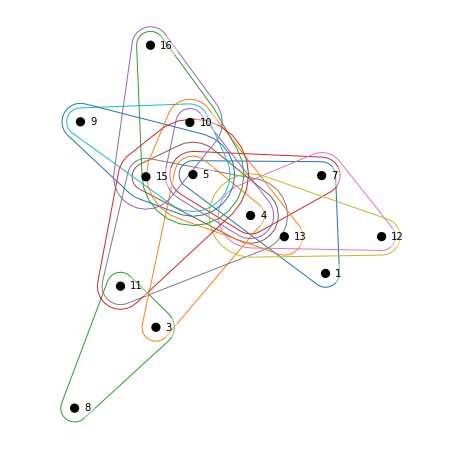

In [51]:
Humi_restrict_edges3 = Humi.restrict_to_edges(list(e for e in edges_umi if len(edges_umi[e])==3))
hnx.draw(Humi_restrict_edges3, with_edge_labels=False)

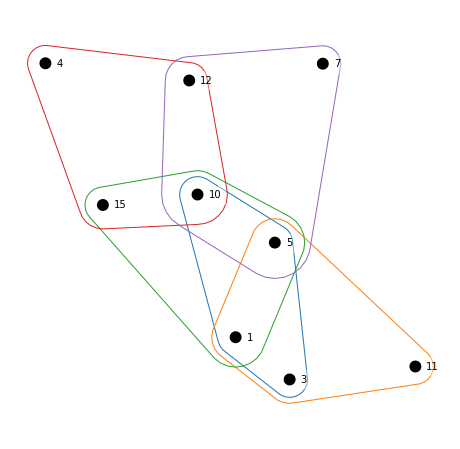

In [52]:
Humi_restrict_edges4 = Humi.restrict_to_edges(list(e for e in edges_umi if len(edges_umi[e])==4))
hnx.draw(Humi_restrict_edges4,with_edge_labels=False)

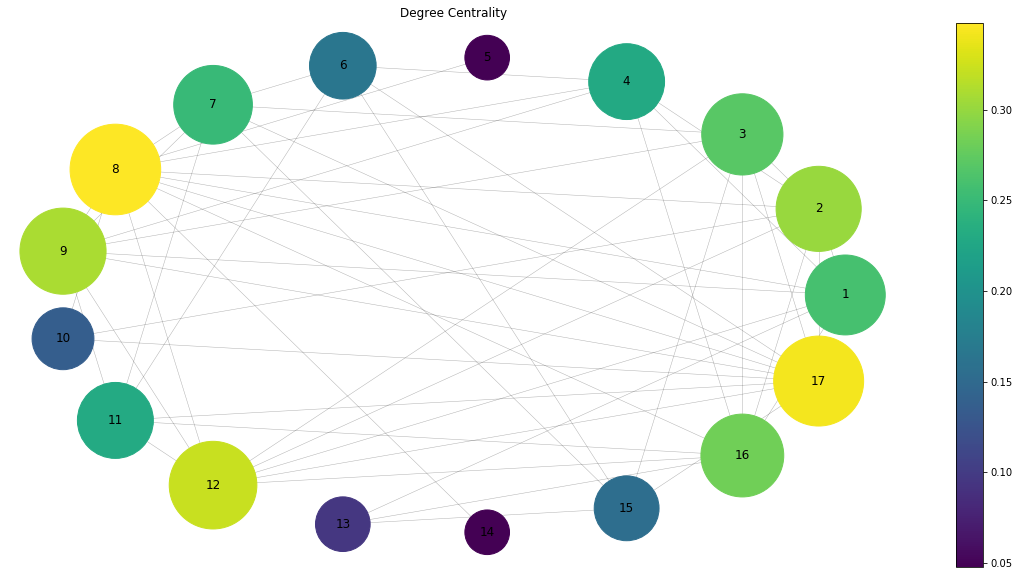

In [151]:
G = nx.Graph(Adj2_umi)     #define graph
pos = nx.circular_layout(G)  # compute graph layout
degree = nx.eigenvector_centrality(G)     #compute degree centrality

plt.figure(figsize=(20, 10))   
plt.axis('off')
plt.title('Degree Centrality')

#define nodes with color and size depending on degree
nodes = nx.draw_networkx_nodes(G, pos, node_size= list(12**4*i+1000 for i in degree.values()), cmap=plt.cm.viridis,
                       node_color=list(i for i in degree.values()), nodelist=list(degree.keys()))
#nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1))
labels=nx.draw_networkx_labels(G,pos, labels=n_labels)
#draw edges
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.3)
plt.colorbar(nodes)
plt.show(G)